In [101]:
# IMPORTANDO OS PACOTES
import pandas as pd
import requests as req
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [73]:
url_weight = 'https://apisidra.ibge.gov.br/values/t/6613/n1/all/v/9319/p/all/c11255/90687,90691,90696,90707,93404,93405,93406,93407,93408/d/v9319%201'
r_weight = req.get(url_weight)
raw_weight = r_weight.json()

In [75]:
df_weight = pd.DataFrame(raw_weight)
df_weight.columns = df_weight.iloc[0]
df_weight.drop(0, inplace=True)
df_weight.head()
df_weight.drop(df_weight.columns[[0,1,2,3,5,6,7,8,10,11]], axis=1, inplace=True)
df_weight['Valor'] = df_weight['Valor'].astype(float)

tri_dict = {}

pd.set_option('mode.chained_assignment', None)

for tri in list(df_weight['Trimestre (Código)'].unique()):
    df_tri = df_weight[df_weight['Trimestre (Código)']==tri]
    gdp_total = df_tri[df_tri['Setores e subsetores']=='PIB a preços de mercado']['Valor'].values
    df_tri['peso'] = df_tri['Valor']/gdp_total
    tri_dict[tri] = df_tri
pd.set_option('mode.chained_assignment', 'warn')


In [76]:
url = 'https://apisidra.ibge.gov.br/values/t/5932/n1/all/v/6564/p/last/c11255/90687,90691,90696,90707,93404,93405,93406,93407,93408/d/v6561%201'
r = req.get(url)
raw = r.json()

In [109]:
df = pd.DataFrame(raw)
df.columns = df.iloc[0]
df.drop(0, inplace=True)
df.drop(df.columns[[0,1,2,3,5,6,8,10,11]], axis=1, inplace=True)
last_tri = df['Trimestre (Código)'].values[0]
df['Valor'] = df['Valor'].astype(float)

dict_convert = {'Agropecuária - total': 'Agropecuária',
                'Indústria - total': 'Indústria',
                'Serviços - total': 'Serviços',
                'PIB a preços de mercado': 'PIB a preços de mercado',
                'Despesa de consumo das famílias': 'Consumo das Famílias',
                'Despesa de consumo da administração pública': 'Consumo do Governo',
                'Formação bruta de capital fixo': 'FBKF',
                'Exportação de bens e serviços': 'Exportação',
                'Importação de bens e serviços (-)': 'Importação'}



In [110]:
df_plot = pd.merge(df, tri_dict[last_tri][['Setores e subsetores', 'peso']], 
                   on='Setores e subsetores', how='left')
df_plot['contribuicao'] = df_plot['Valor']*df_plot['peso']
df_plot['color'] = np.where(df_plot.contribuicao > 0, 'blue', 'red')
df_plot['Setores e subsetores'] = df_plot['Setores e subsetores'].replace(dict_convert)

In [111]:
def plot_marginal():
    sns.set_theme()
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='contribuicao', y='Setores e subsetores', data=df_plot,
                hue='color', dodge=False, 
                ci=None, palette=df_plot['color'].unique(),
                order=df_plot.sort_values(by='contribuicao')['Setores e subsetores']);

    for p in ax.patches:
        width = p.get_width()    
        if np.isfinite(width):
            plt.text(width, p.get_y() + p.get_height() / 2, f'{width:.2f}%', ha='left', va='center')

    ax.legend_.remove();
    plt.xlabel(None);
    plt.ylabel(None);
    plt.title('PIB e Contribuição por setor \n (Trimestre imediatamente anterior)');
    plt.show();



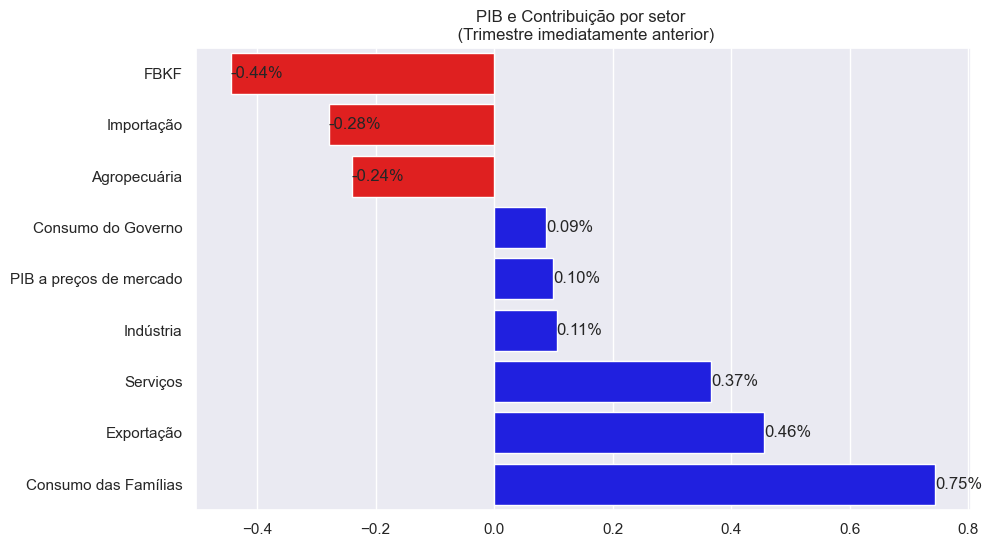

In [112]:
plot_marginal()